<a href="https://colab.research.google.com/github/siabang35/Twitter_Emotion_Detection/blob/choice/UP_NLP_Classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nama   : Wildan Assyidiq
# Kelas  : Goldfarb
# Domain : Natural Language Processing (NLP)

Twitter Emotion Detection & Classification
---

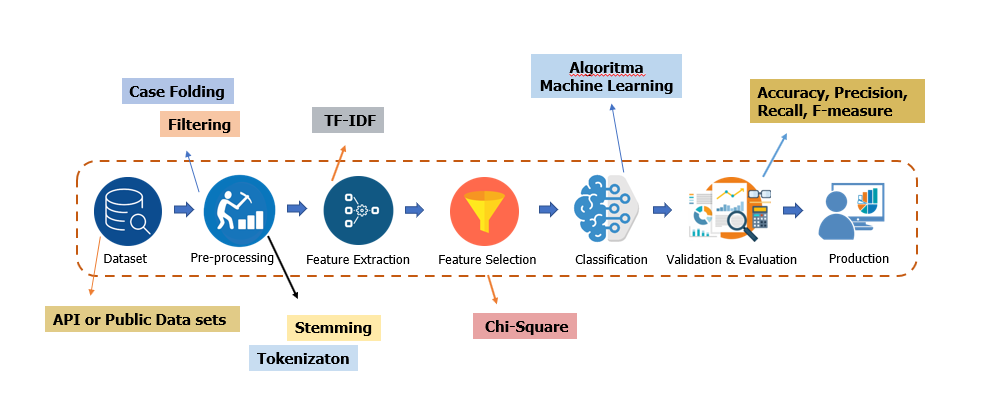

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import io
from textblob import Word
import re
import sys, os, csv
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 18 kB/s 


In [ ]:
#Importing libraries
import re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [ ]:
# Install library Sastrawi
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 5.2 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 01 Data Acquisition

Penjelasan Label 
* 0: Happy
* 1: Anger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Twitter_Emotion_Dataset.csv')
data.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4401 non-null   object
 1   tweet   4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [ ]:
def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower())
dictionary = Counter(words(open('/content/drive/MyDrive/kamus_singkatan2.csv').read()))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def prep(tweet):
    """pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", str(tweet))
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', str(tweet))
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    tweet = tweet.strip()"""
    
    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    tweet = re.sub('\d+', '', str(tweet))
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)     
        
    ps = PorterStemmer()
    words = tweet.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    tweet = " ".join(lemma_words)
    
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = tweet.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    tweet = " ".join(clean_words)
    
    tweet = tweet.strip()
    return tweet

def vectorise_label(label):
    if label == "empty":return 0
    elif label == "sadness":return 2
    elif label == "enthusiasm":return 1
    elif label == "neutral":return 0
    elif label == "worry":return 2
    elif label == "surprise":return 1
    elif label == "love":return 3
    elif label == "fun":return 1
    elif label == "hate":return 4
    elif label == "happiness":return 1
    elif label == "boredom":return 0
    elif label == "relief":return 1
    elif label == "anger":return 4

In [ ]:
print('Total tweet:', data.shape[0], 'tweet\n')
print('terdiri dari (label):')
print('-- [0] Happy:', data[data.label == 0].shape[0], 'happy')
print('-- [1] Anger:', data[data.label == 1].shape[0], 'anger')
print('-- [2] Sadness:', data[data.label == 2].shape[0], 'sadness')
print('-- [3] Love:', data[data.label == 3].shape[0], 'love')
print('-- [4] Fear:', data[data.label == 4].shape[0], 'fear')



Total tweet: 4401 tweet

terdiri dari (label):
-- [0] Happy: 0 happy
-- [1] Anger: 0 anger
-- [2] Sadness: 0 sadness
-- [3] Love: 0 love
-- [4] Fear: 0 fear


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Twitter_Emotion_Dataset.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data_train.shape)

Dataset shape: (4401, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


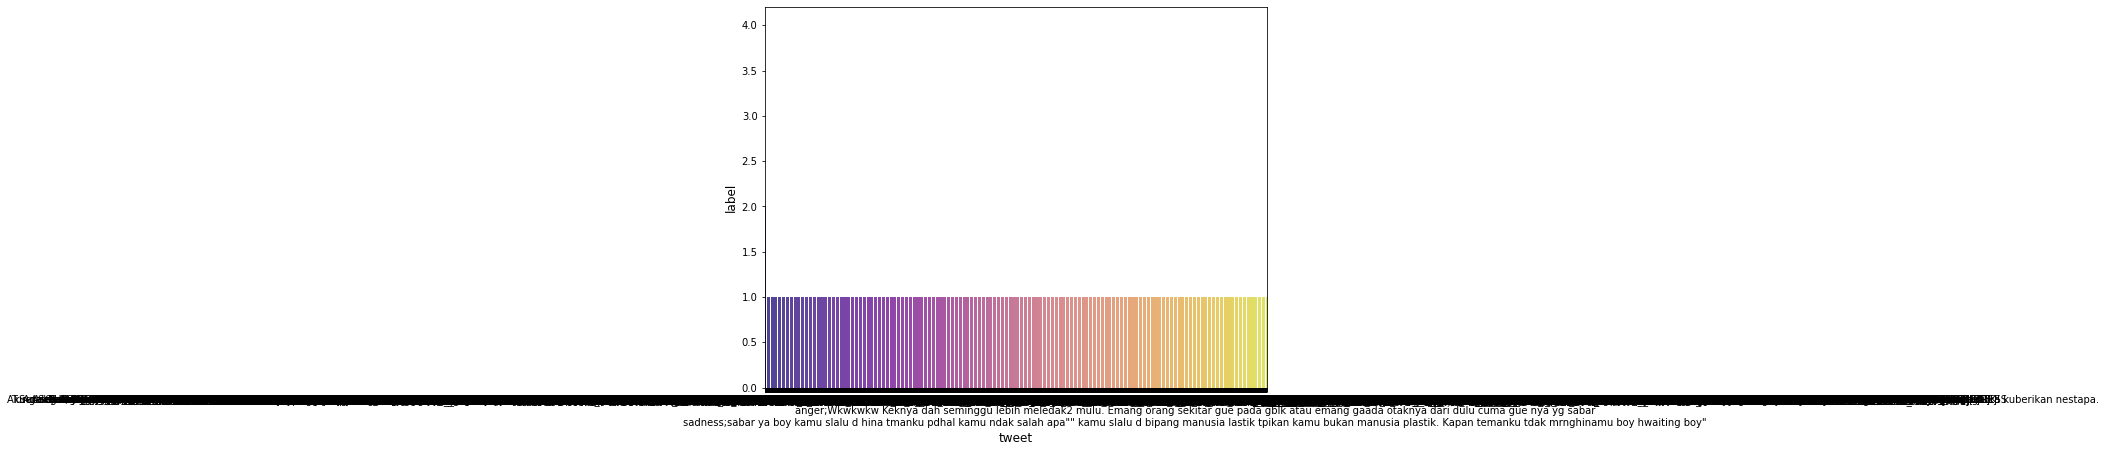

In [ ]:
count  = data_train.iloc[:,1].value_counts()
plt.figure(figsize=(9,7))
sns.barplot(count.index, count.values, alpha=0.8, palette="plasma")
plt.ylabel('label', fontsize=12)
plt.xlabel('tweet', fontsize=12)
plt.show()
# 0 = happy
# 1 = anger
# 2 = Sadness
# 3 = Love
# 4 = Fear 

In [ ]:
X_train = data_train.iloc[:,0][:4100]
#[:4100]
y_train = data_train.iloc[:,-1][:4100]
#[:4100]
X_val = data_train.iloc[:,0][4101:]
#[4101:]
y_val = data_train.iloc[:,-1][4101:]
#[4101:]

In [ ]:
tfidf = TfidfVectorizer(max_features=2000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train.astype('U'))
X_val_tfidf = tfidf.fit_transform(X_val.astype('U'))
print(tfidf.vocabulary_)

{'love': 3, 'sadness': 4, 'fear': 1, 'anger': 0, 'happy': 2}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


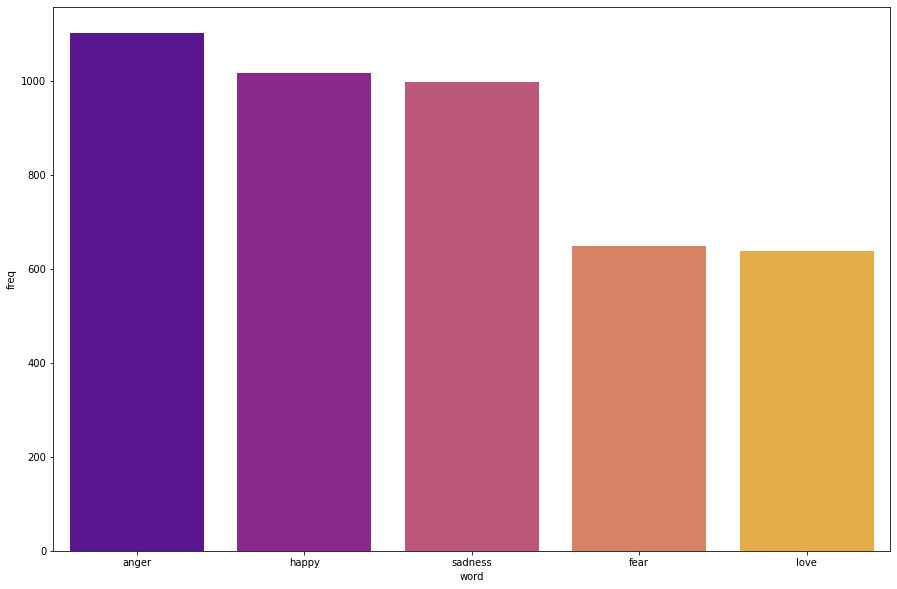

In [ ]:
bow = tfidf.fit_transform(data_train.iloc[:,0].astype('U'))
word_freq = dict(zip(tfidf.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

## Count Vectorizer

In [ ]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_train.iloc[:,0].astype('U'))
X_train_count =  count_vect.transform(X_train.astype('U'))
X_val_count =  count_vect.transform(X_val.astype('U'))
print(count_vect.vocabulary_)

{'anger': 0, 'happy': 2, 'sadness': 4, 'love': 3, 'fear': 1}


(4401, 5)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


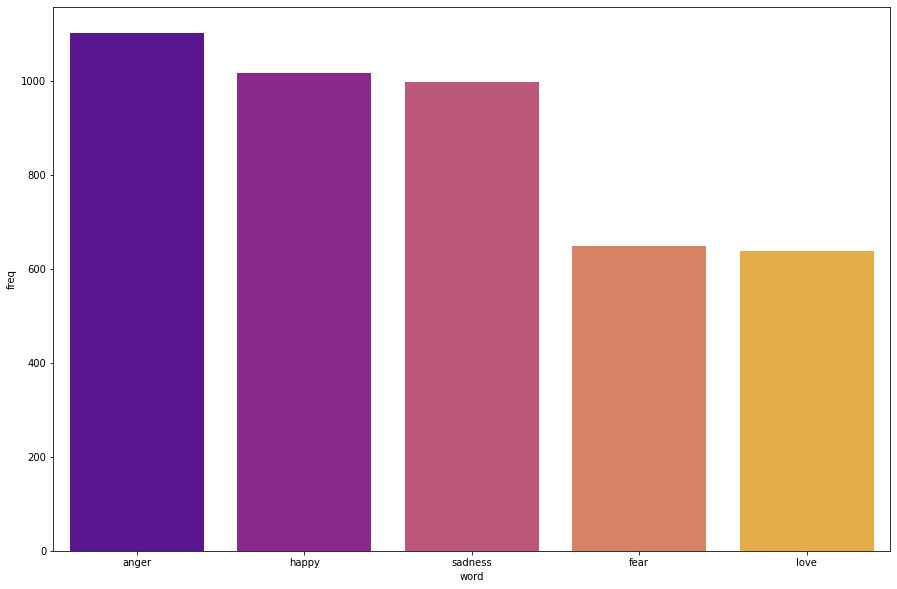

In [ ]:
bow = count_vect.fit_transform(data_train.iloc[:,0].astype('U'))
print(bow.shape)
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

# 02 Text Preprocessing

## Case Folding

In [ ]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
raw_sample = data['tweet'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Case folding	:  dari sekian banyak thread yang aku baca thread ini paling aneh sih dalam penulisan sumpah aneh bgt mau ngatain lebay aja segala bikin thread hadeh aku juga ga jago nulis tapi tulisan aku ga seberantakan thread mbaknya


## Word Normalization

In [ ]:
key_norm = pd.read_csv('/content/drive/MyDrive/kamus_singkatan2.csv')
print(key_norm.head())

key_norm.shape

   singkat;hasil\n
0      aamiin;amin
1        adek;adik
2      adlh;adalah
3          aer;air
4  aiskrim;es krim


(1309, 1)

In [ ]:
def text_normalize(text):
  
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['akhir', 'anda', 'adik']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
raw_sample = data['tweet'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Case folding		:  dari sekian banyak thread yang aku baca thread ini paling aneh sih dalam penulisan sumpah aneh bgt mau ngatain lebay aja segala bikin thread hadeh aku juga ga jago nulis tapi tulisan aku ga seberantakan thread mbaknya
Stopword removal	:  sekian thread baca thread aneh sih penulisan sumpah aneh bgt ngatain lebay aja bikin thread hadeh ga jago nulis tulisan ga seberantakan thread mbaknya


## Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample = data['tweet'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Case folding		:  dari sekian banyak thread yang aku baca thread ini paling aneh sih dalam penulisan sumpah aneh bgt mau ngatain lebay aja segala bikin thread hadeh aku juga ga jago nulis tapi tulisan aku ga seberantakan thread mbaknya
Stopword removal	:  sekian thread baca thread aneh sih penulisan sumpah aneh bgt ngatain lebay aja bikin thread hadeh ga jago nulis tulisan ga seberantakan thread mbaknya
Stemming		:  sekian thread baca thread aneh sih tulis sumpah aneh bgt ngatain lebay aja bikin thread hadeh ga jago nulis tulis ga beranta thread mbak


In [ ]:
def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F" #emoticon
      u"\U0001F300-\U0001F5FF" #symbols and pictographs
      u"\U0001F1E0-\U0001F1FF" #flags(ios)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"  
      "]+",
      flags=re.UNICODE,
  )
  return emoji_pattern.sub(r"",string)

## Text Preprocessing Pipeline

In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  text = remove_emoji(text)
  return text

In [ ]:
%%time
data['clean_text'] = data['tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 28min 33s, sys: 5.85 s, total: 28min 39s
Wall time: 28min 45s


In [ ]:
data

,label,tweet,clean_text
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",jln jatibarupolisi tdk bs gertak gubernur eman...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",cewe lho kayak rasain sibuk jaga rasain sakit ...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jln jatibarubagian wilayah tn abangpengaturan ...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing alam aja kemarin jam batalin tiket sta...
...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahu papa mejam mata tahan gejolak batin papa ...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",depan nggak lha iya gimana coba lulus seni bis...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,username beneran mahasiswa teknik ui nembak pa...


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [ ]:
# Pisahkan kolom fitur dan target
X = data['clean_text']
y = data['label']

In [ ]:
X

0       jln jatibarupolisi tdk bs gertak gubernur eman...
1       cewe lho kayak rasain sibuk jaga rasain sakit ...
2       kepingin gudeg mbarek bu hj amad foto google s...
3       jln jatibarubagian wilayah tn abangpengaturan ...
4       sharing alam aja kemarin jam batalin tiket sta...
                              ...                        
4396    tahu papa mejam mata tahan gejolak batin papa ...
4397    sulit tetap calon wapresnya jokowi pilpres sal...
4398    depan nggak lha iya gimana coba lulus seni bis...
4399    username beneran mahasiswa teknik ui nembak pa...
4400           ya allah engkau sakit hati sembuh ya allah
Name: clean_text, Length: 4401, dtype: object

In [ ]:
y

0         anger
1         anger
2         happy
3         anger
4         happy
         ...   
4396       love
4397       fear
4398      anger
4399      happy
4400    sadness
Name: label, Length: 4401, dtype: object

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [ ]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [ ]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

14688


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aa' 'aaa' 'aaaaaa' ... 'zonknya' 'zuhri' 'zulkifli']


In [ ]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aaa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaak,aaaahhh,aaah,aaahhhh,aaamiiinnn,...,zmn,zohri,zon,zona,zonasi,zonk,zonkies,zonknya,zuhri,zulkifli
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [ ]:
X = data['clean_text']
y = data['label']

In [ ]:
X

0       jln jatibarupolisi tdk bs gertak gubernur eman...
1       cewe lho kayak rasain sibuk jaga rasain sakit ...
2       kepingin gudeg mbarek bu hj amad foto google s...
3       jln jatibarubagian wilayah tn abangpengaturan ...
4       sharing alam aja kemarin jam batalin tiket sta...
                              ...                        
4396    tahu papa mejam mata tahan gejolak batin papa ...
4397    sulit tetap calon wapresnya jokowi pilpres sal...
4398    depan nggak lha iya gimana coba lulus seni bis...
4399    username beneran mahasiswa teknik ui nembak pa...
4400           ya allah engkau sakit hati sembuh ya allah
Name: clean_text, Length: 4401, dtype: object

In [ ]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

14688


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aaa' 'aaaaaa' ... 'zonknya' 'zuhri' 'zulkifli']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aaa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaak,aaaahhh,aaah,aaahhhh,aaamiiinnn,...,zmn,zohri,zon,zona,zonasi,zonk,zonkies,zonknya,zuhri,zulkifli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 14688
Reduced feature number: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,1.698465
1,0.732229
2,0.787031
3,0.942370
4,1.265329
...,...
14683,0.517724
14684,0.765771
14685,1.398093
14686,0.854324


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,1.698465,aa
1,0.732229,aaa
2,0.787031,aaaaaa
3,0.942370,aaaaaaa
4,1.265329,aaaaaaaaa
...,...,...
14683,0.517724,zonk
14684,0.765771,zonkies
14685,1.398093,zonknya
14686,0.854324,zuhri


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2292,283.483218,cinta
12906,226.410858,takut
11581,188.095883,sayang
11054,65.506381,rem
9099,63.342848,ngeri
...,...,...
11692,0.063480,sedap
2478,0.062836,cuek
9472,0.057146,nyari
7172,0.042055,layar


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False, False, False])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'abis',
 'acara',
 'adem',
 'adipati',
 'adu',
 'agama',
 'agus',
 'aim',
 'aja',
 'akhri',
 'akumencintamu',
 'akun',
 'al',
 'alami',
 'alas',
 'album',
 'alhamdulilah',
 'alhamdulillah',
 'alhasil',
 'all',
 'allaah',
 'allah',
 'alquran',
 'aman',
 'amin',
 'amp',
 'ana',
 'anakanaknya',
 'andai',
 'aneh',
 'angan',
 'anies',
 'anjay',
 'anjing',
 'anjir',
 'anniv',
 'anniversary',
 'antri',
 'anugerah',
 'anxiety',
 'apain',
 'aq',
 'arah',
 'arguement',
 'army',
 'asa',
 'asih',
 'asik',
 'askmf',
 'asli',
 'asumsi',
 'asyik',
 'atur',
 'awet',
 'ayah',
 'ayu',
 'baby',
 'baca',
 'back',
 'bacot',
 'bagi',
 'bahagia',
 'bahak',
 'bahaya',
 'baik',
 'bait',
 'banci',
 'bandit',
 'bandung',
 'banget',
 'bangga',
 'bangun',
 'banjir',
 'banteng',
 'banyak',
 'baring',
 'barokah',
 'bau',
 'bawel',
 'bayanginnya',
 'bayar',
 'bb',
 'bca',
 'bego',
 'bei',
 'bela',
 'belai',
 'beliau',
 'belok',
 'benarbenar',
 'benci',
 'benda',
 'benerbener',
 'berani',
 'berat',
 'berha

In [ ]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [ ]:
kbest_feature

{'tdk': 13048,
 'gubernur': 4489,
 'polisi': 10494,
 'jgn': 5726,
 'politik': 10496,
 'atur': 820,
 'sabar': 11340,
 'username': 14054,
 'url': 14040,
 'sibuk': 12150,
 'jaga': 5513,
 'sakit': 11400,
 'haid': 4609,
 'panik': 9914,
 'pulang': 10743,
 'malem': 7669,
 'gimana': 4303,
 'wajar': 14197,
 'korban': 6785,
 'takut': 12906,
 'bela': 1283,
 'temanteman': 13135,
 'bagi': 928,
 'indah': 5223,
 'gub': 4486,
 'yg': 14594,
 'otak': 9749,
 'aja': 207,
 'lancar': 7095,
 'antri': 591,
 'baca': 891,
 'aneh': 502,
 'sih': 12165,
 'bgt': 1481,
 'ngatain': 8938,
 'lebay': 7199,
 'hadeh': 4572,
 'ga': 3965,
 'mbak': 7921,
 'temen': 13143,
 'tuh': 13752,
 'lu': 7480,
 'ngerasa': 9087,
 'berat': 1367,
 'hujan': 5035,
 'gak': 4011,
 'tidur': 13438,
 'tuduh': 13748,
 'dasar': 2626,
 'lebaran': 7195,
 'dilema': 2999,
 'rumah': 11302,
 'min': 8245,
 'rakyat': 10893,
 'indonesia': 5240,
 'tinggal': 13475,
 'presiden': 10601,
 'fansite': 3773,
 'uang': 13857,
 'syukur': 12831,
 'doa': 3210,
 'sulit':

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abis,acara,adem,adipati,adu,agama,agus,aim,aja,...,yaallahsmoga,yaelah,yahudi,yap,yg,yoona,you,yu,yuta,zina
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.056278,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102218,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

# Model 1 Mutinominal 

In [ ]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [ ]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [ ]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model1 = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model1, filename='model_1.joblib')

['model_1.joblib']

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model1_pred = model1.predict(X_test)

# Tampilkan hasil prediksi label dari model
model1_pred

array(['happy', 'happy', 'anger', 'anger', 'happy', 'fear', 'sadness',
       'happy', 'anger', 'anger', 'anger', 'happy', 'anger', 'sadness',
       'happy', 'happy', 'happy', 'love', 'anger', 'anger', 'sadness',
       'anger', 'anger', 'sadness', 'anger', 'happy', 'sadness', 'happy',
       'anger', 'sadness', 'happy', 'anger', 'anger', 'love', 'happy',
       'anger', 'anger', 'anger', 'sadness', 'love', 'happy', 'anger',
       'anger', 'sadness', 'anger', 'happy', 'anger', 'sadness', 'anger',
       'sadness', 'fear', 'happy', 'happy', 'fear', 'sadness', 'anger',
       'sadness', 'anger', 'happy', 'anger', 'sadness', 'anger',
       'sadness', 'happy', 'happy', 'happy', 'sadness', 'fear', 'anger',
       'anger', 'sadness', 'anger', 'anger', 'anger', 'happy', 'love',
       'anger', 'anger', 'anger', 'happy', 'happy', 'love', 'sadness',
       'happy', 'sadness', 'sadness', 'love', 'happy', 'fear', 'love',
       'anger', 'happy', 'fear', 'anger', 'sadness', 'happy', 'happy',
  

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['happy', 'happy', 'fear', 'anger', 'happy', 'fear', 'sadness',
       'happy', 'sadness', 'happy', 'sadness', 'happy', 'anger',
       'sadness', 'love', 'happy', 'love', 'love', 'sadness', 'anger',
       'sadness', 'happy', 'anger', 'sadness', 'happy', 'happy',
       'sadness', 'happy', 'happy', 'sadness', 'happy', 'sadness',
       'anger', 'sadness', 'happy', 'sadness', 'fear', 'anger', 'happy',
       'love', 'happy', 'anger', 'anger', 'sadness', 'anger', 'happy',
       'anger', 'love', 'fear', 'sadness', 'fear', 'happy', 'happy',
       'fear', 'happy', 'happy', 'fear', 'anger', 'love', 'anger',
       'anger', 'anger', 'sadness', 'happy', 'happy', 'love', 'anger',
       'fear', 'sadness', 'happy', 'sadness', 'anger', 'anger', 'happy',
       'love', 'love', 'sadness', 'anger', 'anger', 'happy', 'anger',
       'sadness', 'sadness', 'happy', 'sadness', 'love', 'love', 'happy',
       'fear', 'love', 'sadness', 'love', 'fear', 'fear', 'sadness',
       'sadness', 'happy'

# Model 2 LSVM

In [ ]:
# Training the model
lsvm = SGDClassifier(alpha=0.005, random_state=100, max_iter=15, tol=None) # Load algoritma pembelajaran
model2 = lsvm.fit(X_train, y_train)            # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model2, filename='model_2.joblib')

['model_2.joblib']

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model2_pred = model2.predict(X_test)

# Tampilkan hasil prediksi label dari model
model2_pred

array(['happy', 'happy', 'anger', 'happy', 'love', 'fear', 'sadness',
       'happy', 'anger', 'anger', 'happy', 'happy', 'anger', 'sadness',
       'love', 'happy', 'happy', 'love', 'anger', 'happy', 'sadness',
       'anger', 'anger', 'sadness', 'anger', 'happy', 'sadness', 'happy',
       'anger', 'fear', 'love', 'anger', 'anger', 'love', 'happy',
       'anger', 'fear', 'anger', 'sadness', 'love', 'happy', 'anger',
       'anger', 'sadness', 'anger', 'happy', 'anger', 'love', 'anger',
       'sadness', 'fear', 'happy', 'happy', 'fear', 'sadness', 'anger',
       'fear', 'anger', 'love', 'anger', 'sadness', 'anger', 'sadness',
       'happy', 'happy', 'love', 'fear', 'fear', 'sadness', 'anger',
       'sadness', 'anger', 'anger', 'anger', 'love', 'love', 'anger',
       'anger', 'anger', 'happy', 'happy', 'love', 'sadness', 'happy',
       'sadness', 'love', 'love', 'happy', 'fear', 'love', 'anger',
       'love', 'fear', 'fear', 'happy', 'happy', 'happy', 'love', 'anger',
       's

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['happy', 'happy', 'fear', 'anger', 'happy', 'fear', 'sadness',
       'happy', 'sadness', 'happy', 'sadness', 'happy', 'anger',
       'sadness', 'love', 'happy', 'love', 'love', 'sadness', 'anger',
       'sadness', 'happy', 'anger', 'sadness', 'happy', 'happy',
       'sadness', 'happy', 'happy', 'sadness', 'happy', 'sadness',
       'anger', 'sadness', 'happy', 'sadness', 'fear', 'anger', 'happy',
       'love', 'happy', 'anger', 'anger', 'sadness', 'anger', 'happy',
       'anger', 'love', 'fear', 'sadness', 'fear', 'happy', 'happy',
       'fear', 'happy', 'happy', 'fear', 'anger', 'love', 'anger',
       'anger', 'anger', 'sadness', 'happy', 'happy', 'love', 'anger',
       'fear', 'sadness', 'happy', 'sadness', 'anger', 'anger', 'happy',
       'love', 'love', 'sadness', 'anger', 'anger', 'happy', 'anger',
       'sadness', 'sadness', 'happy', 'sadness', 'love', 'love', 'happy',
       'fear', 'love', 'sadness', 'love', 'fear', 'fear', 'sadness',
       'sadness', 'happy'

# Model 3 Logistik Regression

In [ ]:
logreg = LogisticRegression(C=9, max_iter=500)
model3 = logreg.fit(X_train, y_train)
# Simpan model hasil traning
dump(model3, filename='model_3.joblib')

['model_3.joblib']

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model3_pred = model3.predict(X_test)

# Tampilkan hasil prediksi label dari model
model3_pred

array(['happy', 'happy', 'fear', 'happy', 'love', 'fear', 'sadness',
       'happy', 'anger', 'anger', 'happy', 'happy', 'anger', 'sadness',
       'happy', 'happy', 'happy', 'love', 'sadness', 'anger', 'sadness',
       'anger', 'anger', 'sadness', 'happy', 'happy', 'sadness', 'happy',
       'anger', 'sadness', 'happy', 'anger', 'anger', 'sadness', 'happy',
       'anger', 'anger', 'anger', 'sadness', 'love', 'happy', 'anger',
       'anger', 'sadness', 'anger', 'happy', 'anger', 'love', 'anger',
       'sadness', 'fear', 'happy', 'happy', 'fear', 'sadness', 'anger',
       'fear', 'anger', 'love', 'anger', 'anger', 'anger', 'sadness',
       'happy', 'happy', 'happy', 'fear', 'fear', 'happy', 'happy',
       'sadness', 'anger', 'anger', 'anger', 'love', 'love', 'anger',
       'anger', 'anger', 'happy', 'happy', 'love', 'sadness', 'happy',
       'sadness', 'love', 'love', 'happy', 'fear', 'sadness', 'anger',
       'happy', 'fear', 'fear', 'sadness', 'happy', 'happy', 'happy',
    

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['happy', 'happy', 'fear', 'anger', 'happy', 'fear', 'sadness',
       'happy', 'sadness', 'happy', 'sadness', 'happy', 'anger',
       'sadness', 'love', 'happy', 'love', 'love', 'sadness', 'anger',
       'sadness', 'happy', 'anger', 'sadness', 'happy', 'happy',
       'sadness', 'happy', 'happy', 'sadness', 'happy', 'sadness',
       'anger', 'sadness', 'happy', 'sadness', 'fear', 'anger', 'happy',
       'love', 'happy', 'anger', 'anger', 'sadness', 'anger', 'happy',
       'anger', 'love', 'fear', 'sadness', 'fear', 'happy', 'happy',
       'fear', 'happy', 'happy', 'fear', 'anger', 'love', 'anger',
       'anger', 'anger', 'sadness', 'happy', 'happy', 'love', 'anger',
       'fear', 'sadness', 'happy', 'sadness', 'anger', 'anger', 'happy',
       'love', 'love', 'sadness', 'anger', 'anger', 'happy', 'anger',
       'sadness', 'sadness', 'happy', 'sadness', 'love', 'love', 'happy',
       'fear', 'love', 'sadness', 'love', 'fear', 'fear', 'sadness',
       'sadness', 'happy'

# 05 Model Evaluation (Machine Learning)

## Evaluation Model Multinominal 

In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model1_pred == y_test).sum()
prediksi_salah = (model1_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 544
Jumlah prediksi salah	: 337
Akurasi pengujian	: 61.74801362088536 %


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model1_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[187   0   6   0  19]
 [ 34  61   8   0  34]
 [ 54   0 130   1  32]
 [  5   0  33  57  28]
 [ 60   0  17   6 109]]


In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model1_pred))

Classification report:
               precision    recall  f1-score   support

       anger       0.55      0.88      0.68       212
        fear       1.00      0.45      0.62       137
       happy       0.67      0.60      0.63       217
        love       0.89      0.46      0.61       123
     sadness       0.49      0.57      0.53       192

    accuracy                           0.62       881
   macro avg       0.72      0.59      0.61       881
weighted avg       0.68      0.62      0.61       881



In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model1, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.60726447 0.62883087 0.64812713 0.60839955 0.65266742 0.64018161
 0.66061294 0.60726447 0.6015891  0.59250851] 

Rata-rata akurasi pada cross validation: 0.624744608399546


# Evaluation Model LSVM

In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model2_pred == y_test).sum()
prediksi_salah = (model2_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 587
Jumlah prediksi salah	: 294
Akurasi pengujian	: 66.62883087400681 %


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model2_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[175   5  10   2  20]
 [ 18 103   3   2  11]
 [ 46   7 118  19  27]
 [  2   4  12 102   3]
 [ 42   7  24  30  89]]


In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model2_pred))

Classification report:
               precision    recall  f1-score   support

       anger       0.62      0.83      0.71       212
        fear       0.82      0.75      0.78       137
       happy       0.71      0.54      0.61       217
        love       0.66      0.83      0.73       123
     sadness       0.59      0.46      0.52       192

    accuracy                           0.67       881
   macro avg       0.68      0.68      0.67       881
weighted avg       0.67      0.67      0.66       881



In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model2, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.64358683 0.67990919 0.59931896 0.63564132 0.64018161 0.6708286
 0.64245176 0.66515323 0.63564132 0.65039728] 

Rata-rata akurasi pada cross validation: 0.6463110102156641


# Evaluation Model Logistik Reggression


In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model3_pred == y_test).sum()
prediksi_salah = (model3_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 598
Jumlah prediksi salah	: 283
Akurasi pengujian	: 67.87741203178207 %


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model3_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[165   4  16   0  27]
 [ 16  98   7   1  15]
 [ 28   4 145   6  34]
 [  3   3  24  80  13]
 [ 36   3  31  12 110]]


In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model3_pred))

Classification report:
               precision    recall  f1-score   support

       anger       0.67      0.78      0.72       212
        fear       0.88      0.72      0.79       137
       happy       0.65      0.67      0.66       217
        love       0.81      0.65      0.72       123
     sadness       0.55      0.57      0.56       192

    accuracy                           0.68       881
   macro avg       0.71      0.68      0.69       881
weighted avg       0.69      0.68      0.68       881



In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model3, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.66288309 0.69807037 0.68558456 0.68671964 0.7014756  0.69920545
 0.67309875 0.6969353  0.67650397 0.67423383] 

Rata-rata akurasi pada cross validation: 0.6854710556186152


# 06 Simple Deployment


In [ ]:
from joblib import load

# load model
model_1 = load('model_1.joblib')
model_2 = load('model_2.joblib')
model_3 = load('model_3.joblib')
# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [ ]:
#@title Masukkan Teks Anda:
# happy
# fear
# anger
# saddness
# love
input_text1 = "Ucapkanlah syukur setiap saat, sebab bahagia tidak akan pernah datang untuk seseorang yang tidak dapat menghargai apa yang sudah dimiliki.".encode('utf-8', 'replace').decode() #@param {type:"string"} 
input_text2 = "Aku dulu sangat penakut sampai-sampai aku tidak pernah meninggalkan kursiku selama istirahat makan siang".encode('utf-8', 'replace').decode() #@param {type:"string"}
input_text3 = "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop".encode('utf-8', 'replace').decode() #@param {type:"string"}
input_text4 = "Saya sangat sedih melihat peristiwa sepak bola kemarin :'‑(".encode('utf-8', 'replace').decode() #@param {type:"string"}
input_text5 = "I love My Waifu".encode('utf-8', 'replace').decode() #@param {type:"string"}

pre_input_text1 = text_preprocessing_process(input_text1)   # lakukan text pre processing pada text input
pre_input_text2 = text_preprocessing_process(input_text2)  
pre_input_text3 = text_preprocessing_process(input_text3) 
pre_input_text4 = text_preprocessing_process(input_text4)  
pre_input_text5 = text_preprocessing_process(input_text5) 

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result1 = model_1.predict(tf_idf_vec.fit_transform([pre_input_text1]))  # Lakukan prediksi
result2 = model_2.predict(tf_idf_vec.fit_transform([pre_input_text2]))  # Lakukan prediksi
result3 = model_3.predict(tf_idf_vec.fit_transform([pre_input_text3]))  # Lakukan prediksi
result4 = model_1.predict(tf_idf_vec.fit_transform([pre_input_text4]))  # Lakukan prediksi
result5 = model_2.predict(tf_idf_vec.fit_transform([pre_input_text5]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text1)
print('Hasil Text Preprocessing :', pre_input_text2)
print('Hasil Text Preprocessing :', pre_input_text3)
print('Hasil Text Preprocessing :', pre_input_text4)
print('Hasil Text Preprocessing :', pre_input_text5)


print('Hasil prediksi :',input_text1, str(result1))
print('Hasil prediksi :',input_text2, str(result2))
print('Hasil prediksi :',input_text3, str(result3))
print('Hasil prediksi :',input_text4, str(result4))
print('Hasil prediksi :',input_text5, str(result5))

Hasil Text Preprocessing : ucap syukur bahagia harga milik
Hasil Text Preprocessing : takut sampaisampai tinggal kursi istirahat makan siang
Hasil Text Preprocessing : you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop
Hasil Text Preprocessing : sedih peristiwa sepak bola kemarin
Hasil Text Preprocessing : i love my waifu
Hasil prediksi : Ucapkanlah syukur setiap saat, sebab bahagia tidak akan pernah datang untuk seseorang yang tidak dapat menghargai apa yang sudah dimiliki. ['happy']
Hasil prediksi : Aku dulu sangat penakut sampai-sampai aku tidak pernah meninggalkan kursiku selama istirahat makan siang ['fear']
Hasil prediksi : you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop ['anger']
Hasil prediksi : Saya sangat sedih melihat peristiwa sepak bola kemarin :'‑( ['sadness']
Hasil prediksi : I love My Waifu ['love']


In [ ]:
remove_emoji('👉Ucapkanlah syukur setiap saat,👋 sebab bahagia tidak akan pernah datang 🌞 untuk seseorang yang tidak dapat menghargai apa yang sudah dimiliki ')

'Ucapkanlah syukur setiap saat, sebab bahagia tidak akan pernah datang  untuk seseorang yang tidak dapat menghargai apa yang sudah dimiliki '

## 07 Word Embedding 

### Menggunakan Word2Vec dari Scratch

In [ ]:
# Import library
import gensim

# Lihat versi Gensim yang digunakan
gensim.__version__

'3.6.0'

In [ ]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_text'].apply(lambda x: tokenization(x.lower()))
sentences

0       [jln, jatibarupolisi, tdk, bs, gertak, gubernu...
1       [cewe, lho, kayak, rasain, sibuk, jaga, rasain...
2       [kepingin, gudeg, mbarek, bu, hj, amad, foto, ...
3       [jln, jatibarubagian, wilayah, tn, abangpengat...
4       [sharing, alam, aja, kemarin, jam, batalin, ti...
                              ...                        
4396    [tahu, papa, mejam, mata, tahan, gejolak, bati...
4397    [sulit, tetap, calon, wapresnya, jokowi, pilpr...
4398    [depan, nggak, lha, iya, gimana, coba, lulus, ...
4399    [username, beneran, mahasiswa, teknik, ui, nem...
4400    [ya, allah, engkau, sakit, hati, sembuh, ya, a...
Name: clean_text, Length: 4401, dtype: object

In [ ]:
# Defenisikan parameter training Word2Vec

EMBEDDING_SIZE = 100    # Dimensi word vektor / neuron pada projection (hidden) layer
WINDOW_SIZE = 5         # Window size. Jarak maksimum antara kata saat ini dan yang diprediksi dalam sebuah
MIN_WORD  = 1           # Model akan mengabaikan semua kata dengan frekuensi total lebih rendah dari ini (opsional)
EPOCH = 10              # Jumlah iterasi (epoch).
SG = 1                  # Strategi algoritma pelatihan: 1 untuk skip-gram, 0 untuk CBOW
NEGATIVE = 5            # Negative sampling. Jika 0, negative sampling tidak digunakan

In [ ]:
%%time 

# Proses training Word2Vec
from gensim.models import Word2Vec, FastText, KeyedVectors

model_word2vec = Word2Vec(sentences, size=EMBEDDING_SIZE, sg=SG, min_count=MIN_WORD, window=WINDOW_SIZE, negative=NEGATIVE, iter=EPOCH)

CPU times: user 11.8 s, sys: 92.9 ms, total: 11.9 s
Wall time: 7.78 s


In [ ]:
# Save Word2Vec sebagai full model
model_word2vec.save('myvec-word2vec-100.model')

In [ ]:
# Save Word2Vec sebagai wordvectors. Hanya menyimpan kata & trained embeddingnya
word2vec_word_vectors = model_word2vec.wv
word2vec_word_vectors.save('myvec-word2vec-100.wordvectors')

In [ ]:
# Cari nilai vektor dari kata tertentu
model_word2vec.wv['jokowi']

array([ 8.0647662e-02, -3.5817730e-01, -2.6184782e-01, -1.3930601e-01,
       -6.2050760e-01,  3.5989381e-02,  2.3186292e-01, -3.3842824e-02,
       -1.5785004e-01,  7.2949536e-02, -1.9699621e-01,  1.5226024e-01,
       -6.9946066e-02,  1.4703101e-01,  1.3918912e-01, -2.2018524e-01,
        2.8374481e-01,  2.3484492e-01, -1.6825290e-02,  5.2832644e-02,
       -4.7326073e-02,  3.3658445e-01,  2.6108041e-01, -1.7813799e-01,
        1.5900238e-01, -4.0719174e-02, -6.9009654e-02, -2.4794534e-01,
        2.9586145e-01,  3.4190762e-01, -3.6042549e-02, -2.4949755e-01,
        2.4690810e-01,  2.1428873e-01, -6.2126696e-02, -1.4403461e-01,
        6.4840071e-02,  7.0235975e-02, -5.2902956e-02,  6.0222764e-04,
        2.2040719e-01, -5.8494544e-01,  7.0964578e-03, -6.7894429e-02,
        5.6978643e-02, -3.5006171e-01,  3.3489358e-01,  2.3201074e-01,
        2.8277045e-01, -3.1660214e-02,  4.5999628e-01, -3.4797382e-01,
        8.7341778e-02,  1.8062878e-02,  3.4014350e-01,  4.9349435e-02,
      

In [ ]:
# Menemukan kata kata teratas yang paling mirip dari kata terentu
# Menghitung kesamaan dari vektor bobot proyeksi dari kata-kata yang diberikan dan vektor untuk setiap kata dalam model.

model_word2vec.wv.most_similar('jokowi')

[('pimpin', 0.9873709082603455),
 ('hukum', 0.9826521277427673),
 ('bangsa', 0.980762779712677),
 ('perintah', 0.9797812104225159),
 ('koruptor', 0.9788081645965576),
 ('partai', 0.9779531955718994),
 ('masyarakat', 0.9779154062271118),
 ('dukung', 0.9770841598510742),
 ('rakyat', 0.9767826795578003),
 ('islam', 0.9759930968284607)]

In [ ]:
# Kata-kata yang ingin kita plot vektornya
word_list = ['jokowi', 'masyarakat','pimpin','hukum', 'jabat', 'koruptor', 'partai', 'perintah', 'bangsa', 'islam', 'dukung']

In [ ]:
# daftar vektor dari kata-kata tersebut
word_vectors = np.array([model_word2vec.wv[w] for w in word_list])
print(word_vectors)

[[ 0.08064766 -0.3581773  -0.26184782 ...  0.13876954 -0.25579715
  -0.03780387]
 [ 0.10400515 -0.3198458  -0.27691594 ...  0.12306926 -0.2409323
  -0.12502906]
 [ 0.00960025 -0.45602995 -0.29282853 ...  0.18602206 -0.29527095
   0.03305642]
 ...
 [ 0.06191164 -0.3942649  -0.2592621  ...  0.13492845 -0.27201027
  -0.07626276]
 [ 0.05893342 -0.4381116  -0.2711192  ...  0.16055858 -0.27932718
  -0.07575644]
 [ 0.00622552 -0.41878876 -0.2738934  ...  0.12033908 -0.2621095
  -0.02952469]]


In [ ]:
# Reduksi dimensi vektor ke 2D menggunakan PCA
from sklearn.decomposition import PCA, KernelPCA

dimred = PCA(n_components=2, copy=False, whiten=True)
red_word_vectors = dimred.fit_transform(word_vectors)

In [ ]:
# Lihat vektor hasil PCA (dari 5 dimensi menjadi 2 dimensi)
red_word_vectors

array([[-0.07701772,  0.6841728 ],
       [ 0.07924586, -0.40835002],
       [-1.123749  ,  0.5222305 ],
       [ 0.98031026, -0.6357009 ],
       [ 1.7420541 ,  0.8320274 ],
       [ 1.225547  , -0.53909385],
       [ 0.18861999, -1.0212892 ],
       [-0.43460402,  2.3430538 ],
       [-1.1902609 , -0.4738569 ],
       [-1.2517638 , -0.8738477 ],
       [-0.13838238, -0.4293455 ]], dtype=float32)

In [ ]:
def plot(datas, labels, fc='yellow'):
  # plot the dots
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(datas[:, 0], datas[:, 1], marker='o')

  # annotate labels
  for label, x, y in zip(labels, datas[:, 0], datas[:, 1]):
    plt.annotate(label, \
                 xy=(x, y), xytext=(-15, 15), \
                 textcoords='offset points', ha='right', va='bottom', \
                 bbox=dict(boxstyle='round,pad=0.3', fc=fc, alpha=0.5), \
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.show()

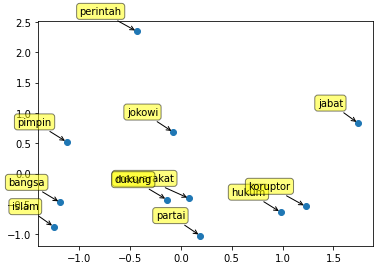

In [ ]:
plot(red_word_vectors, word_list)

## Mempersiapkan data untuk dilakukan embedding

### Text to Sequence

#### Tokenizing Data
Proses ini berbeda dengan tokenization pada text-preprocessing. Pada pemodelan dengan deep learning, tokenization merujuk pada membuat dictionary berdasarkan dataset.

In [ ]:
'''
Proses vektorisasi teks dengan mengubah setiap teks menjadi token urutan bilangan int (setiap bilangan int menjadi indeks token dalam dictionary) 
'''
from keras.preprocessing.text import Tokenizer

In [ ]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(data['clean_text'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

14715


In [ ]:
# Lihat dictionary hasil tokenisasi
WV_DICTIONARY

{'<unk>': 1,
 'username': 2,
 'yg': 3,
 'ya': 4,
 'ga': 5,
 'aja': 6,
 'url': 7,
 'orang': 8,
 'kalo': 9,
 'gue': 10,
 'cinta': 11,
 'sayang': 12,
 'udah': 13,
 'gak': 14,
 'takut': 15,
 'banget': 16,
 'sih': 17,
 'nya': 18,
 'tau': 19,
 'gitu': 20,
 'suka': 21,
 'gw': 22,
 'salah': 23,
 'pas': 24,
 'tp': 25,
 'anak': 26,
 'ku': 27,
 'hati': 28,
 'bikin': 29,
 'kasih': 30,
 'jalan': 31,
 'gua': 32,
 'hidup': 33,
 'bgt': 34,
 'si': 35,
 'moga': 36,
 'sampe': 37,
 'bilang': 38,
 'biar': 39,
 'allah': 40,
 'kali': 41,
 'makan': 42,
 'sakit': 43,
 'rumah': 44,
 'liat': 45,
 'kau': 46,
 'pake': 47,
 'emang': 48,
 'tuh': 49,
 'jd': 50,
 'kerja': 51,
 'org': 52,
 'terima': 53,
 'jam': 54,
 'kayak': 55,
 'temen': 56,
 'jg': 57,
 'gin': 58,
 'ajar': 59,
 'gimana': 60,
 'udh': 61,
 'karna': 62,
 'pikir': 63,
 'deh': 64,
 'lu': 65,
 'ken': 66,
 'krn': 67,
 'bener': 68,
 'selamat': 69,
 'pulang': 70,
 'baca': 71,
 'bahagia': 72,
 'jatuh': 73,
 'sm': 74,
 'klo': 75,
 'tinggal': 76,
 'langsung': 77,

### Menentukan Max Length

In [ ]:
MAX_SEQ_LENGTH = 100

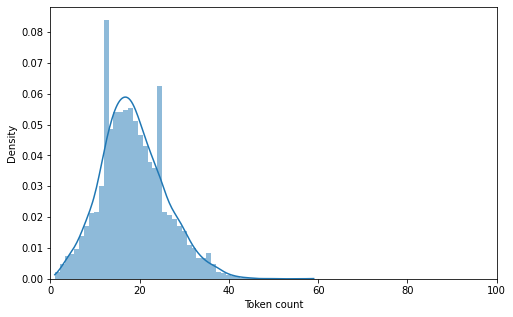

In [ ]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for text in data['clean_text']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
# Lihat hasil setelah di ubah menjadi sequences
print(data['clean_text'][10])
print(data_seq[10])

min rakyat indonesia harap nya tinggal tni lihat serang kantor media unsur pidana hina presiden indonesia sah lucu lucu an tni url
[1, 1, 84, 1, 18, 76, 1, 1, 1, 1, 1, 1, 1, 1, 1, 84, 1, 1, 1, 1, 1, 7]


In [ ]:
# Proses mengubah token hasil tokenisasi menjadi urutan bilangan int berdasarkan index dictionary.
data_seq = tokenizer.texts_to_sequences(data['clean_text'])

### Add Padding & Truncation

In [ ]:
#Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
#num_timesteps adalah argumen maxlen jika disediakan, atau panjang dari sequence terpanjang dalam daftar.

#Sequence yang lebih pendek dari num_timesteps diisi dengan nilai hingga panjangnya sama dengan num_timesteps (padding).
#Sequence yang lebih panjang dari num_timesteps dipotong sehingga sesuai dengan panjang yang diinginkan (truncate)....

from keras.preprocessing.sequence import pad_sequences

In [ ]:
PADDING = 'post'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'post'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [ ]:
print(data['clean_text'][10])
print('panjang {}'.format(len(sentences[10])))
print(data_seq[10])
print(data_pad[10])

min rakyat indonesia harap nya tinggal tni lihat serang kantor media unsur pidana hina presiden indonesia sah lucu lucu an tni url
panjang 22
[1, 1, 84, 1, 18, 76, 1, 1, 1, 1, 1, 1, 1, 1, 1, 84, 1, 1, 1, 1, 1, 7]
[ 1  1 84  1 18 76  1  1  1  1  1  1  1  1  1 84  1  1  1  1  1  7  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


### One-Hot Encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#Y = to_categorical(data['label'], num_classes=len(data['label'].unique()))  # Lakukan one-hot encoding pada label (y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()


In [ ]:
y = labelencoder.fit_transform(data['label'])

In [ ]:
Y = to_categorical(y, num_classes=len(y))  # Lakukan one-hot encoding pada label (y)

In [ ]:
type(Y)

numpy.ndarray

### Training and Testing

In [ ]:
# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data_pad, Y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3520, 100), (881, 100), (3520, 4401), (881, 4401))

#Lexicon Based

In [ ]:
dataset_emotion = data

In [ ]:
dataset_emotion

,label,tweet,clean_text
0,anger,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...
1,anger,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...
2,happy,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...
4,happy,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...
...,...,...,...
4396,love,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...
4397,fear,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,anger,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...
4399,happy,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...


In [ ]:
def polaritas(teks):
  if teks =='positive':
    return 1
  elif teks =='negative':
    return -1

In [ ]:
dataset_emotion

,label,tweet,clean_text
0,anger,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...
1,anger,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...
2,happy,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...
4,happy,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...
...,...,...,...
4396,love,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...
4397,fear,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,anger,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...
4399,happy,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...


In [ ]:
dataset_emotion['label'] = dataset_emotion['tweet'].apply(polaritas)

In [ ]:
dataset_emotion

,label,tweet,clean_text
0,None,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...
1,None,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...
2,None,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...
3,None,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...
4,None,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...
...,...,...,...
4396,None,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...
4397,None,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,None,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...
4399,None,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...


In [ ]:
print('Total Jumlah Tweets:', dataset_emotion.shape[0], 'dataset_emotion\n')
print('terdiri dari (label):')
print('-- [1] Negatif\t\t:', dataset_emotion[dataset_emotion.label == -1].shape[0], 'dataset')
print('-- [-1] Positif\t\t:', dataset_emotion[dataset_emotion.label == 1].shape[0], 'dataset\n')

Total Jumlah Tweets: 4401 dataset_emotion

terdiri dari (label):
-- [1] Negatif		: 0 dataset
-- [-1] Positif		: 0 dataset



In [ ]:
dataset_emotion['clean_text'] = dataset_emotion['tweet'].apply(text_preprocessing_process)

In [ ]:
dataset_emotion

,label,tweet,clean_text
0,None,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...
1,None,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...
2,None,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...
3,None,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...
4,None,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...
...,...,...,...
4396,None,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...
4397,None,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,None,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...
4399,None,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...


In [ ]:
##load data
!git clone https://github.com/fajri91/InSet.git

fatal: destination path 'InSet' already exists and is not an empty directory.


In [ ]:
negative_word = pd.read_csv('/content/InSet/negative.tsv', delimiter="\t")
positive_word = pd.read_csv('/content/InSet/positive.tsv', delimiter="\t")

In [ ]:
# concatenating 2 dataframe
vertical_concat = pd.concat([negative_word, positive_word], axis=0)

In [ ]:
#vertical_concat.to_csv('/content/drive/MyDrive/PIL/XLNET/kamus_inset_lexicon.csv',index=False)

In [ ]:
inset_lexicon = vertical_concat
inset_lexicon

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5
...,...,...
3604,melarikan,3
3605,vakansi,3
3606,spesial,4
3607,asrama,3


In [ ]:
inset_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10218 entries, 0 to 3608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    10218 non-null  object
 1   weight  10218 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 239.5+ KB


In [ ]:
#ubah ke dictionary
kamus_inset_lexicon = dict(zip(inset_lexicon.word, inset_lexicon.weight))

In [ ]:
kamus_inset_lexicon

{'putus tali gantung': -2,
 'gelebah': 2,
 'gobar hati': -2,
 'tersentuh (perasaan)': -1,
 'isak': -5,
 'larat hati': -3,
 'nelangsa': -3,
 'remuk redam': -5,
 'tidak segan': 2,
 'gemar': 5,
 'tak segan': 2,
 'sesal': 1,
 'pengen': 3,
 'penghayatan': 3,
 'absorpsi': 3,
 'linu': 4,
 'salah benang': -1,
 'sakit': -5,
 'lara': -5,
 'zuhud': 2,
 'mencederai': -4,
 'mengingkari': -4,
 'maaf': 2,
 'mengkhianat': -4,
 'mencelakai': -5,
 'mulu': 2,
 'ngga': -2,
 'borong': 2,
 'lever': -2,
 'kasian': -3,
 'gamau': -4,
 'doang': 1,
 'pulas': 4,
 'abis': 1,
 'coba': 2,
 'kangen': 3,
 'kalau': -1,
 'maunya': -1,
 'seandainya': -1,
 'marilah': 1,
 'bener': 3,
 'yaudah': 1,
 'nggak': 1,
 'gatau': -1,
 'apaan': -4,
 'ngakak': -2,
 'atuh': -1,
 'sekali': -1,
 'menarik hati': 3,
 'cedayam': 2,
 'kece': 5,
 'termakan': 1,
 'belom': 1,
 'malem': -1,
 'mencekau': -2,
 'menduga': 3,
 'menyuarakan': 3,
 'memprediksi': 3,
 'membunyikan': 2,
 'menerka': 3,
 'menaksir': 3,
 'mengantisipasi': 3,
 'nangis': -5,


In [ ]:
def polarity_score(text):
    words = text.split()
    new_text = []

    for word in words:
        word_s = word.lower()
        if word_s in kamus_inset_lexicon:
            new_text.append(kamus_inset_lexicon[word_s])
        else:
            new_text.append('0')
    score = new_text
    return score

In [ ]:
polarity_score('saya mencoba melakukan analisis pada dataset emotion')

[-3, '0', '0', 4, -3, '0', '0']

In [ ]:
dataset_emotion['score'] = dataset_emotion['clean_text'].apply(lambda x: polarity_score(x.lower()))

In [ ]:
dataset_emotion

,label,tweet,clean_text,score
0,None,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...,"[0, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, -1, 4, 0, 0..."
1,None,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...,"[0, 0, -3, -3, 4, 2, -3, -5, 0, -4, 0, -1, 0, ..."
2,None,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...,"[0, 0, 0, 0, 0, 0, 3, 0, -2, 1, 0, 0, 2, 2, 3]"
3,None,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,None,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...,"[3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, ..."
...,...,...,...,...
4396,None,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...,"[4, 0, 0, -2, 1, 1, 0, 0, -3, 0, 0, 0, 2]"
4397,None,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...,"[0, 3, 0, 0, 0, 0, -4, 3, 3, -3, 0, 0, 0, 0, 2..."
4398,None,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...,"[0, 1, 0, 0, 0, 2, 5, 1, 0, 0, 2, 0, 1, 0, 3, ..."
4399,None,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...,"[0, 3, 0, -4, 0, 0, 2, 3, 0, 0, -4, 0, 0, 0, 3..."


In [ ]:
def polarity_score(teks) : 
  result = sum(map(int,teks))
  return result

dataset_emotion['polarity score'] = dataset_emotion['score'].apply(polarity_score)
dataset_emotion

,label,tweet,clean_text,score,polarity score
0,None,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...,"[0, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, -1, 4, 0, 0...",4
1,None,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...,"[0, 0, -3, -3, 4, 2, -3, -5, 0, -4, 0, -1, 0, ...",-16
2,None,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...,"[0, 0, 0, 0, 0, 0, 3, 0, -2, 1, 0, 0, 2, 2, 3]",9
3,None,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,None,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...,"[3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, ...",11
...,...,...,...,...,...
4396,None,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...,"[4, 0, 0, -2, 1, 1, 0, 0, -3, 0, 0, 0, 2]",3
4397,None,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...,"[0, 3, 0, 0, 0, 0, -4, 3, 3, -3, 0, 0, 0, 0, 2...",1
4398,None,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...,"[0, 1, 0, 0, 0, 2, 5, 1, 0, 0, 2, 0, 1, 0, 3, ...",18
4399,None,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...,"[0, 3, 0, -4, 0, 0, 2, 3, 0, 0, -4, 0, 0, 0, 3...",4


In [ ]:
def polarity_to_label(x):
    if(x <= 0):
        return -1
    else:
        return 1

In [ ]:
dataset_emotion['hasil'] = dataset_emotion['polarity score'].apply(polarity_to_label)

In [ ]:
dataset_emotion

,label,tweet,clean_text,score,polarity score,hasil
0,None,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...,"[0, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, -1, 4, 0, 0...",4,1
1,None,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...,"[0, 0, -3, -3, 4, 2, -3, -5, 0, -4, 0, -1, 0, ...",-16,-1
2,None,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...,"[0, 0, 0, 0, 0, 0, 3, 0, -2, 1, 0, 0, 2, 2, 3]",9,1
3,None,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,1
4,None,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...,"[3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, ...",11,1
...,...,...,...,...,...,...
4396,None,tahukah kamu bahwa saat itu papa memejamkan ma...,tahu papa mejam mata tahan gejolak batin papa ...,"[4, 0, 0, -2, 1, 1, 0, 0, -3, 0, 0, 0, 2]",3,1
4397,None,sulitnya menetapkan calon wapresnya jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...,"[0, 3, 0, 0, 0, 0, -4, 3, 3, -3, 0, 0, 0, 0, 2...",1,1
4398,None,masa depannya nggak jelas lha iya gimana mau j...,depan nggak lha iya gimana coba lulus seni bis...,"[0, 1, 0, 0, 0, 2, 5, 1, 0, 0, 2, 0, 1, 0, 3, ...",18,1
4399,None,username dulu beneran ada mahasiswa teknik ui ...,username beneran mahasiswa teknik ui nembak pa...,"[0, 3, 0, -4, 0, 0, 2, 3, 0, 0, -4, 0, 0, 0, 3...",4,1


##Lexicon

In [ ]:
X_lexicon = dataset_emotion
y_lexicon = dataset_emotion['tweet']

X_train_lexicon, X_test_lexicon, y_train_lexicon, y_test_lexicon = train_test_split(X_lexicon, y_lexicon, test_size=0.2, random_state=40)

In [ ]:
y_prediksi_leksikon = X_test_lexicon['tweet']

In [ ]:
#evaluasi dari lexicon
accuracy_score(y_test_lexicon,y_prediksi_leksikon)

1.0

## 08 Modelling (Deep Learning)

## Model using LSTM + Word2vec

In [ ]:
X = data['tweet']
y = Y

In [ ]:
X_train ,X_test, y_train ,y_test =train_test_split(X,y ,test_size=0.3)

### Load Word2vec


In [ ]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.wv.vocab     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

14713
100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
word2vec_dict = {}

for word in my_word2vec_vocab:
    word2vec_dict[word] = my_word2vec.wv.get_vector(word)   
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # Harus sama dengan ukuran vocab word2vec

The numbers of key-value pairs:  14713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


### Create Embedding

In [ ]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [ ]:
# Cek index keberapa di Word2Vec vocabulary dari suatu kata
print(WV_DICTIONARY.get('pemerintah'))

None


In [ ]:
# Cek vector dari suatu kata
print(EMBEDDING_MATRIX[25])

[-0.05260776 -0.23355606 -0.13060644 -0.24701509 -0.41432771 -0.04285809
 -0.11559036 -0.25888419  0.00186385  0.11315041 -0.2388142  -0.04977259
 -0.24532665  0.22472581  0.09167644 -0.23415841  0.10793278  0.05981119
 -0.0673302  -0.21186212 -0.10436991  0.16087395  0.4760043  -0.27361572
  0.08173706 -0.2170618  -0.08479236 -0.07273044  0.19004661  0.04146251
 -0.11497665  0.05089092  0.14591318  0.27507842  0.15381025  0.01483299
  0.34625238  0.04887249  0.10816965  0.22452895  0.25374299 -0.0260621
 -0.02157779  0.13562495  0.10838716 -0.10205491 -0.00604782  0.10155362
  0.40730631  0.13565069  0.19851334 -0.11959283  0.18290731  0.10684542
  0.34521845 -0.13892826  0.35576719  0.00091663  0.1466524  -0.05917008
  0.15751499 -0.34305799  0.15098688 -0.10593017  0.22240491 -0.19822624
  0.25250867 -0.08288978 -0.45464337  0.19346642  0.13186975 -0.09530433
 -0.20328705 -0.1181313   0.13723476 -0.4689672   0.12209785  0.26700169
  0.23397736  0.17634495 -0.24937332 -0.43312529 -0.

In [ ]:
# Cek dimensi word vector. X = jumlah kata pada vocabulary, y = dimensi vektor
EMBEDDING_MATRIX.shape

(14715, 100)

### Define Model

In [ ]:
'''
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

model_LSTM_w2v = Sequential()
model_LSTM_w2v.add(Embedding(                                           # Buat embedding layer yang menerima panjang dictionary hasil Tokenisasi
    input_dim = WV_DICTIONARY_SIZE,                                 # banyaknya token 
    input_length = MAX_SEQ_LENGTH,                                  #60 kata per kalimat
    output_dim = 64))      
model_LSTM_w2v.add(LSTM(64))                                            # Tambahkan satu layer LSTM
model_LSTM_w2v.add(Dropout(0.5))                             
model_LSTM_w2v.add(Dense(3, activation='softmax'))

In [ ]:
model_LSTM_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           941760    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 974,979
Trainable params: 974,979
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

In [ ]:
#Compile model
model_LSTM_w2v.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training

In [ ]:
%%time

EPOCH = 10
BATCH_SIZE = 64
history_LSTM = model_LSTM_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))


Epoch 1/10


ValueError: ignored

### Evaluate

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_BiLSTM_w2v.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_BiLSTM_w2v.evaluate(X_test, y_test)

In [ ]:
# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_BiLSTM_w2v.history['accuracy'][i], history_BiLSTM_w2v.history['loss'][i], history_BiLSTM_w2v.history['val_accuracy'][i], history_BiLSTM_w2v.history['val_loss'][i]))

## Bidirectional Long short term memory network (Bi-LSTM) + Word2Vec
Contoh sebelumnya kita hanya menggunakan dictionary yang dihasilkan ketika proses Tokenizing. Lalu, ketika pemodelan ditambahkan layer embedding sebelum di fitkan ke layer LSTM.


Selanjutnya, kita akan memanfaatkan word2vec yang telah dilatih pada proses sebelumnya untuk mengubah teks menjadi bentuk vektor.





### Load Word2Vec

In [ ]:
# Load word2vec yang telah kita simpan
from gensim.models import KeyedVectors

my_word2vec = KeyedVectors.load('myvec-word2vec-100.wordvectors', mmap='r')
my_word2vec_vocab = my_word2vec.wv.vocab     

VOCAB_SIZE = len(my_word2vec_vocab)
EMBEDDING_SIZE = my_word2vec.vector_size

print(VOCAB_SIZE)
print(EMBEDDING_SIZE)

14713
100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
word2vec_dict = {}

for word in my_word2vec_vocab:
    word2vec_dict[word] = my_word2vec.wv.get_vector(word)   
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # Harus sama dengan ukuran vocab word2vec

The numbers of key-value pairs:  14713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


### Create Embedding Matrix

In [ ]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
  embed_vector = word2vec_dict.get(word)
  if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
    EMBEDDING_MATRIX[i] = embed_vector

In [ ]:
# Cek index keberapa di Word2Vec vocabulary dari suatu kata
print(WV_DICTIONARY.get('saya'))

4120


In [ ]:
# Cek vector dari suatu kata
print(EMBEDDING_MATRIX[25])

[-0.05260776 -0.23355606 -0.13060644 -0.24701509 -0.41432771 -0.04285809
 -0.11559036 -0.25888419  0.00186385  0.11315041 -0.2388142  -0.04977259
 -0.24532665  0.22472581  0.09167644 -0.23415841  0.10793278  0.05981119
 -0.0673302  -0.21186212 -0.10436991  0.16087395  0.4760043  -0.27361572
  0.08173706 -0.2170618  -0.08479236 -0.07273044  0.19004661  0.04146251
 -0.11497665  0.05089092  0.14591318  0.27507842  0.15381025  0.01483299
  0.34625238  0.04887249  0.10816965  0.22452895  0.25374299 -0.0260621
 -0.02157779  0.13562495  0.10838716 -0.10205491 -0.00604782  0.10155362
  0.40730631  0.13565069  0.19851334 -0.11959283  0.18290731  0.10684542
  0.34521845 -0.13892826  0.35576719  0.00091663  0.1466524  -0.05917008
  0.15751499 -0.34305799  0.15098688 -0.10593017  0.22240491 -0.19822624
  0.25250867 -0.08288978 -0.45464337  0.19346642  0.13186975 -0.09530433
 -0.20328705 -0.1181313   0.13723476 -0.4689672   0.12209785  0.26700169
  0.23397736  0.17634495 -0.24937332 -0.43312529 -0.

In [ ]:
# Cek dimensi word vector. X = jumlah kata pada vocabulary, y = dimensi vektor
EMBEDDING_MATRIX.shape

(14715, 100)

### Define Model (Bi LSTM)
Nah, sekarang kita membahkan layer embedding berdasarkan matrix embedding yang di dapatkan dari word2vec yang sudah kita latih sebelumnya. Selain itu, kita akan mencoba menggunakan arsitektur Bidirectional LSTM.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.initializers import Constant

model_BiLSTM_w2v = Sequential()
model_BiLSTM_w2v.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    trainable = True,
    embeddings_initializer = Constant(EMBEDDING_MATRIX)))
model_BiLSTM_w2v.add(Bidirectional(LSTM(64)))
model_LSTM_w2v.add(Dropout(0.5))  
model_BiLSTM_w2v.add(Dense(3, activation='softmax'))

In [ ]:
model_BiLSTM_w2v.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1471500   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,556,367
Trainable params: 1,556,367
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_BiLSTM_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [ ]:
%%time

EPOCH = 20
BATCH_SIZE = 32

history_BiLSTM_w2v = model_BiLSTM_w2v.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/20


ValueError: ignored

In [ ]:
plot_graphs(history_BiLSTM_w2v, 'accuracy')
plot_graphs(history_BiLSTM_w2v, 'loss')

NameError: ignored

### Evaluate

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_BiLSTM_w2v.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model_BiLSTM_w2v.evaluate(X_test, y_test)

In [ ]:
# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true))

## 09 Modelling (Transfer Learning)

### Model BERT Fine Tuning

### Data Aquisition

In [ ]:
# Copy data
raw_data = data.copy()

### Text Preprocessing 

In [ ]:
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
%time data['tweet'] = data['tweet'].apply(text_preprocessing)

CPU times: user 82.2 ms, sys: 1.82 ms, total: 84 ms
Wall time: 85.6 ms


In [ ]:
data.head()

,label,tweet,clean_text
0,anger,soal jln jatibarupolisi tdk bs gertak gubernur...,jln jatibarupolisi tdk bs gertak gubernur eman...
1,anger,sesama cewe lho kayaknya harusnya bisa lebih r...,cewe lho kayak rasain sibuk jaga rasain sakit ...
2,happy,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jln jatibarubagian dari wilayah tn abangpengat...,jln jatibarubagian wilayah tn abangpengaturan ...
4,happy,sharing pengalaman aja kemarin jam batalin ti...,sharing alam aja kemarin jam batalin tiket sta...


## Training and Testing Splitting

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

df_train.shape, df_test.shape, df_val.shape

((3520, 2), (441, 2), (440, 2))

### Load Tokenizer

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 
     |████████████████████████████████| 163 kB 57.5 MB/s 


In [ ]:
import transformers
print(transformers.__version__)

4.22.2


In [ ]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2

In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [ ]:
# Lihat vocabulary dari pre-trained model yang telah di load sebelumnya
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))
print(vocabulary)

Panjang vocabulary: 30521
{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '##an': 5, 'd': 6, '##er': 7, 'm': 8, '##en': 9, 's': 10, 'p': 11, '##ar': 12, 'b': 13, 'k': 14, '##at': 15, '##ang': 16, '##in': 17, 't': 18, '##ak': 19, '##al': 20, '##ah': 21, '##as': 22, '##un': 23, '##am': 24, '##em': 25, 'di': 26, '##ya': 27, '##el': 28, '##ad': 29, '##eng': 30, 'y': 31, '##kan': 32, '##tu': 33, 'yang': 34, 'se': 35, '##ap': 36, '##is': 37, 'l': 38, '##ik': 39, 'h': 40, 'dan': 41, 'j': 42, 'ke': 43, '##il': 44, 'men': 45, '##on': 46, '##it': 47, 'in': 48, 'ber': 49, '##us': 50, '##ga': 51, '##or': 52, '##es': 53, 'ter': 54, '##ing': 55, 'r': 56, '##nya': 57, '##ur': 58, '##akan': 59, 'mem': 60, 'c': 61, 'per': 62, '##ut': 63, '##id': 64, '##ari': 65, '##ul': 66, '##um': 67, 'n': 68, '##ada': 69, '##uk': 70, '##ek': 71, '##ir': 72, '##ol': 73, '##ih': 74, '##engan': 75, '##ung': 76, '##eb': 77, 'un': 78, 'dengan': 79, 'meng': 80, '##tuk': 81, '##ag': 82, 'g': 83, '##et': 84, '#

In [276]:
# Contoh Tokenisasi

id_data = 5 # Mengambil data indeks ke-5 pada dataframe

print('Kalimat:', raw_data.tweet[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.tweet[id_data]))

Kalimat: Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
BERT Tokenizer: ['dari', 'sekian', 'banyak', 'thread', 'yang', 'aku', 'baca', 'thread', 'ini', 'paling', 'aneh', 'sih', 'dalam', 'penulisan', 'sumpah', 'aneh', 'bgt', 'mau', 'nga', '##tain', 'lebay', 'aja', 'segala', 'bikin', 'thread', 'had', '##eh', 'aku', 'juga', 'ga', 'jago', 'nulis', 'tapi', 'tulisan', 'aku', 'ga', 'seber', '##anta', '##kan', 'thread', 'mbak', '##nya']


Input Formating
Teks harus dipecah menjadi token sebelum dimasukkan ke BERT, kemudian token tersebut harus dipetakan ke indeks pada kosakata tokenizer yang telah di load sebelumnya. Tokenisasi harus dilakukan oleh tokenizer yang disertakan dengan BERT.

In [278]:
# Contoh input formatting untuk BERT. Input formating dapat menggunakan fungsi `encode_plus`

bert_input = bert_tokenizer.encode_plus(
    data.tweet[id_data],             # Sample kalimat                
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 50,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [281]:
print('Kalimat\t\t:', raw_data.tweet[id_data])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])   

Kalimat		: Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Tokenizer	: ['[CLS]', 'dari', 'sekian', 'banyak', 'thread', 'yang', 'aku', 'baca', 'thread', 'ini', 'paling', 'aneh', 'sih', 'dalam', 'penulisan', 'sumpah', 'aneh', 'bgt', 'mau', 'nga', '##tain', 'lebay', 'aja', 'segala', 'bikin', 'thread', 'had', '##eh', 'aku', 'juga', 'ga', 'jago', 'nulis', 'tapi', 'tulisan', 'aku', 'ga', 'seber', '##anta', '##kan', 'thread', 'mbak', '##nya', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [2, 98, 5231, 271, 12943, 34, 304, 2064, 12943, 92, 711, 3526, 1966, 112, 5939, 9109, 3526, 6948, 422, 6052, 9689, 25671, 1465, 1517, 2999, 12943, 1165, 134, 304, 186, 525, 11815, 11504, 469, 2436, 304, 525, 4754, 9930, 32, 12943, 4257, 57, 3, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Menentukan Max Length

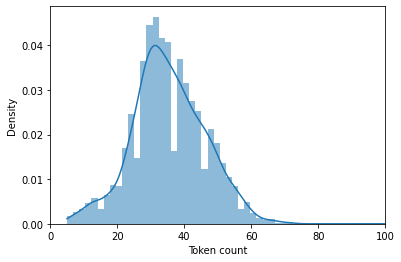

In [283]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for txt in data.tweet:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [284]:
# Dapat dilihat dari grafik diatas, sebagian besar kalimat tampaknya berisi kurang dari 80 token
# Maka, tentukan max_length adalah 80

MAX_LEN = 80 

## Input Formatting data training & testing

In [285]:
# Buat fungsi untuk menggabungkan langkah tokenisasi, menambahkan special tokens untuk keseluruhan data sebagai input formatting ke model BERT
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

In [286]:
# Buat fungsi untuk memetakan input hasil input formatting agar sesuai dengan model BERT
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

In [287]:
# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [288]:
# Tentukan nilai hyperparamter untuk fine-tuning
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

## Pre Training

In [289]:
'''
BERT untuk tugas klasifikasi sequence (teks) dengan menambahkan linear layer di atas pooled output untuk pengklasifikasi
https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification
'''

from transformers import TFBertForSequenceClassification

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)

Downloading:   0%|          | 0.00/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [290]:
# Tentukan optimizer dengan learning rate tertentu
# Paper aslinya menggunakan Adam Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [293]:
%%time
bert_history = bert_model.fit(Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/5


AttributeError: ignored

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCHS):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, bert_history.history['accuracy'][i], bert_history.history['loss'][i], bert_history.history['val_accuracy'][i], bert_history.history['val_loss'][i]))

In [ ]:
bert_model.save_weights('bert-model.h5')

### Evaluate

In [ ]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

In [ ]:
predicted_raw = bert_model.predict(test_encoded)

In [ ]:
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['label'])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy_score(y_true, y_pred)

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
print(classification_report(y_true, y_pred))

### Predict

In [ ]:
# Load hasil fine-tuning
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)
bert_load_model.load_weights('bert-model.h5')

In [ ]:
# Sample text
input_text = 'Special promo Ramadhan, Idul Fitri, dan Arus Balik!'

# Encode input text
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')

In [ ]:
bert_predict = bert_load_model(input_text_tokenized)          # Lakukan prediksi
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         # Softmax function untuk mendapatkan hasil klasifikasi

In [ ]:
sms_labels = ['Normal','Fraud','Promo']

label = tf.argmax(bert_output, axis=1)
label = label.numpy()

In [ ]:
print(input_text, ':', sms_labels[label[0]])